In [1]:
import numpy as np
import pandas as pd

import json
import requests
import googlemaps
from bs4 import BeautifulSoup
import query
import time

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load api keys

key = open('APIkeys.txt', 'r')
goog_key = open('google_places_api_key.txt', 'r')

In [3]:
keys = list(key)

In [4]:
# save keys as strings

api_key = keys[0].split()[2]
goog_api_key = list(goog_key)[0][11:-1]

In [5]:
# instantiate googlemaps object

gmaps = googlemaps.Client(key=goog_api_key)

In [9]:
# Query NYTimes API for 800 reviews by Pete Wells from 2012-2021
urls, restaurants_100, dates = query.review_url_names(api_key, 'Pete Wells', news_desk = 'Dining', type_of_material = 'Review', begin_date = '20120101', end_date = '20210401',n_pages_min = 0, n_pages_max = 80)

In [41]:
# create a dataframe with the returned items
df = pd.DataFrame(index = dates)
df['urls'] = urls
df['restaurants'] = restaurants_100

In [44]:
df.head()

,urls,restaurants
2021-03-08T18:31:52+0000,https://www.nytimes.com/2021/03/08/dining/whea...,wheated pizza washington squares
2021-03-01T18:03:31+0000,https://www.nytimes.com/2021/03/01/dining/winn...,winner
2021-02-12T18:36:55+0000,https://www.nytimes.com/2021/02/12/dining/fala...,falansai vietnamese food
2020-12-01T17:44:20+0000,https://www.nytimes.com/2020/12/01/dining/ayat...,ayat palestinian food
2020-11-23T18:00:37+0000,https://www.nytimes.com/2020/11/23/dining/bila...,bilao


In [43]:
# Remove irrelevant words from the restaurants column
stopwords = ['review', 'pete wells', 'restaurant', 'on the lower east side']

df['restaurants'] = query.remove_stopwords(df['restaurants'], stopwords)

In [65]:
# Reload the saved data

df = pd.read_csv('restaurants.csv')
df.set_index('Unnamed: 0.1', inplace = True)
df.drop(columns = 'Unnamed: 0', inplace = True)

In [67]:
# Drop non-review rows including articles from before Wells was the main Dining critic, roundups and briefs

df = query.drop_rows(['unde', 'rest', 'brief', 'hungry city'], df, 'restaurants')

In [46]:
# Get star ratings for each review if applicable

df['stars'] = query.get_stars(df.urls)

In [49]:
# Convert stars from ASCII to number of stars

df['stars'] = df.stars.apply(lambda i: len(i) if type(i) == str else 0)

In [ ]:
def get_rest_info(rest_names = [], rest_location= 'NYC', fields = [], googlemap_object):
    dct = {}
    for i in rest_names:
        dct.update({i: googlemap_object.find_place(
            i + rest_location, input_type = 'textquery', fields = fields 
            )})
    

In [188]:
dct = {}
for i in list(df.restaurants):
    dct.update({i : gmaps.find_place(i + ' NYC', input_type='textquery', fields = ['name', 'business_status', 'place_id', 'formatted_address'] )})

In [333]:
df1_name = []
business_status = []
formatted_address = []
name = []
place_id = []



for i in dct:
    try:
        df1_name.append(i)
        business_status.append(dct[i]['candidates'][0]['business_status'])
        formatted_address.append(dct[i]['candidates'][0]['formatted_address'])
        name.append(dct[i]['candidates'][0]['name'])
        place_id.append(dct[i]['candidates'][0]['place_id'])
    except (IndexError, KeyError):
        business_status.append(np.NaN)
        formatted_address.append(np.NaN)
        name.append(np.NaN)
        place_id.append(np.NaN)


In [ ]:
def gmaps_dataframe(list_of_restaurants, fields, gmaps_obj):
    dct = {}
    for i in list_of_restaurants:
        dct.update({i : gmaps.find_place(i + ' NYC', input_type='textquery', fields = fields)})
    for i in fields:
        i = []
    

In [334]:
df1 = pd.DataFrame({'status': business_status, 'address':formatted_address, 'restaurants':df1_name, 'place_id': place_id, 'name' :name})

In [368]:
maindf = df.reset_index().merge(df1, how = 'left', on= 'restaurants').set_index('index')

In [420]:
maindf.to_csv('merged.csv')

In [71]:
maindf = pd.read_csv('merged.csv')
maindf.set_index('index', inplace = True)

In [72]:
maindf.head()

,urls,stars,status,address,place_id,name
index,,,,,,
2021-03-08T18:31:52+0000,https://www.nytimes.com/2021/03/08/dining/whea...,0,OPERATIONAL,"905 Church Ave, Brooklyn, NY 11218, United States",ChIJIYCk0DpbwokRZaTcJmohk1Y,Wheated
2021-03-01T18:03:31+0000,https://www.nytimes.com/2021/03/01/dining/winn...,0,OPERATIONAL,"367 7th Ave, Brooklyn, NY 11215, United States",ChIJg8UZJyNbwokR0-LkfR8MPJQ,WINNER
2021-02-12T18:36:55+0000,https://www.nytimes.com/2021/02/12/dining/fala...,0,OPERATIONAL,"112 Harrison Pl, Brooklyn, NY 11237, United St...",ChIJc11gFQJcwokRcOejfRbBPpo,Falansai
2020-12-01T17:44:20+0000,https://www.nytimes.com/2020/12/01/dining/ayat...,0,OPERATIONAL,"8504 3rd Ave, Brooklyn, NY 11209, United States",ChIJBSKRV89PwokRcofsyKk26CM,Ayat
2020-11-23T18:00:37+0000,https://www.nytimes.com/2020/11/23/dining/bila...,0,OPERATIONAL,"1437 1st Avenue Store 1, New York, NY 10021, U...",ChIJierqy1ZZwokR9eCcG1n0hXU,BILAO


In [122]:
def zipcode(address_column):
    zipcodes = []
    for i in address_column:
        zipcodes.append(i.split('United')[0].split(' ')[-2][0:-1])
    return zipcodes

In [124]:
maindf['zipcode'] = zipcode(maindf.address)

In [138]:
maindf = maindf[maindf.zipcode.str.startswith('1')]
maindf = maindf[maindf.zipcode.str.isnumeric()]

In [134]:
def borough_column(address_column):
    borough = []
    for i in address_column:
        borough.append(i.split(', NY')[0].split(' ')[-1])
    for i in range(len(borough)):
        if borough[i] == 'York':
            borough[i] = 'Manhattan'
        elif borough[i] in ['Maspeth', 'Ridgewood', 'Astoria', 'Flushing']:
            borough[i] == 'Queens'
    return borough

In [135]:
borough_column(maindf.address)

['Brooklyn',
 'Brooklyn',
 'Brooklyn',
 'Brooklyn',
 'Manhattan',
 'Manhattan',
 'Manhattan',
 'Queens',
 'Brooklyn',
 'Brooklyn',
 'Brooklyn',
 'Manhattan',
 'Manhattan',
 'Manhattan',
 'Manhattan',
 'Brooklyn',
 'Brooklyn',
 'Brooklyn',
 'Manhattan',
 'Brooklyn',
 'Manhattan',
 'Manhattan',
 'Manhattan',
 'Manhattan',
 'Manhattan',
 'Manhattan',
 'Manhattan',
 'Manhattan',
 'States',
 'Manhattan',
 'Manhattan',
 'Manhattan',
 'Brooklyn',
 'Manhattan',
 'Manhattan',
 'Manhattan',
 'Manhattan',
 'Manhattan',
 'City',
 'Manhattan',
 'Manhattan',
 'Brooklyn',
 'Brooklyn',
 'Manhattan',
 'Manhattan',
 'Manhattan',
 'Manhattan',
 'Manhattan',
 'Manhattan',
 'Manhattan',
 'Brooklyn',
 'Manhattan',
 'Manhattan',
 'Manhattan',
 'Manhattan',
 'Manhattan',
 'Manhattan',
 'Manhattan',
 'Manhattan',
 'Manhattan',
 'Manhattan',
 'Manhattan',
 'Manhattan',
 'Manhattan',
 'Manhattan',
 'Manhattan',
 'Manhattan',
 'Manhattan',
 'Brooklyn',
 'Manhattan',
 'Brooklyn',
 'Point',
 'Manhattan',
 'Manhatta

In [417]:
maindf.drop(columns = 'restaurants', inplace = True)

In [371]:
maindf.dropna(inplace = True)

In [418]:
maindf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 395 entries, 2021-03-08T18:31:52+0000 to 2012-03-27T21:06:49+0000
Data columns (total 6 columns):
urls        395 non-null object
stars       395 non-null int64
status      395 non-null object
address     395 non-null object
place_id    395 non-null object
name        395 non-null object
dtypes: int64(1), object(5)
memory usage: 21.6+ KB


In [349]:
maindf.stars.value_counts()

2    156
0    100
1     94
3     43
4      2
Name: stars, dtype: int64

In [350]:
maindf.status.value_counts()

OPERATIONAL           246
CLOSED_PERMANENTLY     95
CLOSED_TEMPORARILY     54
Name: status, dtype: int64

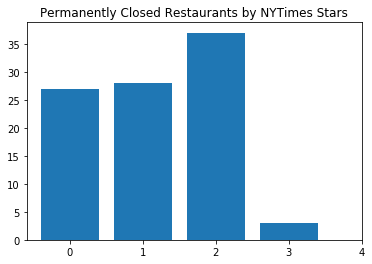

In [388]:
plt.bar(height = maindf[maindf['status'] == 'CLOSED_PERMANENTLY']['stars'].value_counts(), x = maindf[maindf['status'] == 'CLOSED_PERMANENTLY']['stars'].value_counts().index)
plt.title('Permanently Closed Restaurants by NYTimes Stars')
plt.xticks([0,1,2,3,4]);

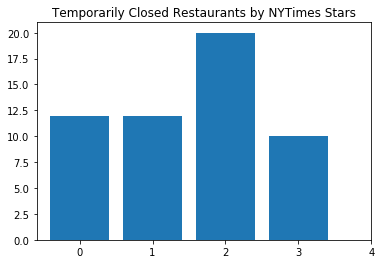

In [390]:
plt.bar(height = maindf[maindf['status'] == 'CLOSED_TEMPORARILY']['stars'].value_counts(), x = maindf[maindf['status'] == 'CLOSED_TEMPORARILY']['stars'].value_counts().index)
plt.title('Temporarily Closed Restaurants by NYTimes Stars')
plt.xticks([0,1,2,3,4]);

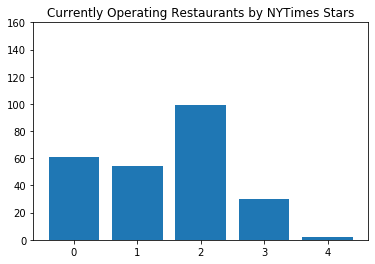

In [396]:
plt.bar(height = maindf[maindf['status'] == 'OPERATIONAL']['stars'].value_counts(), x = maindf[maindf['status'] == 'OPERATIONAL']['stars'].value_counts().index)
plt.title('Currently Operating Restaurants by NYTimes Stars')
plt.xticks([0,1,2,3,4])
plt.ylim(0,160);

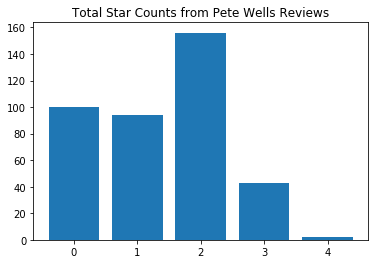

In [394]:
plt.bar(height = maindf['stars'].value_counts(), x = maindf['stars'].value_counts().index)
plt.title('Total Star Counts from Pete Wells Reviews');